# Facial Keypoint Detection Improvement

For the baseline section, we had started from a 2 layer simple neural network and tested some of the additional features from the python blog. The baseline we set was a val_loss of 0.00111 which translate to a Kaggle score of 1.59920. And the baseline model contains 3 convolution,pool, and dropout layer and 2 fully connected layer with data augmentation and changed learning rate.

In this notebook, we are going to starting from this baseline and try to improve the model in various ways. You might not able to see the result directly from the notebook for some of the models here as it gets much longer to train that I directly run it with .py on instance. Result are all saved as net#.out in the same git directory. If size allows, .pickle file is also uploaded in git repo but some are over git's limit.

## 1. Load Data, Libraries, and Functions

In [1]:
## import libraries
import os
import sys
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import _pickle as pickle
import matplotlib.pyplot as pyplot
import theano
from nolearn.lasagne import BatchIterator
from collections import OrderedDict
from sklearn.base import clone

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.4/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# change the directory to where you put the datasets

FTRAIN = '~/Facial_KeyPoints_Detection/training.csv'
FTEST = '~/Facial_KeyPoints_Detection/test.csv'

#FTRAIN = '~/Desktop/W207Final/training.csv'
#FTEST = '~/Desktop/W207Final/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [3]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

## 2. Increase Number of Hidden Layer and Epoch

From the loss-epoch of net6 in the Baseline file, the model is still not overfit and probably not at local minimum yet (train_loss and val_loss is close together and still have a tendency to go down together). This is probably because of the dropout layer we added. So now, I will increase hidden unit from 500 to 1000 and increase epochs from 3000 to 10,000 to get an idea of where it start to get overfitted. If not, how much it improves. I probably don't want to train it more than 10,000 times here consider the resource and time constraint.

In [4]:
# increase las two hidden layer from 500 to 1000 and increase max epochs to 10000#
net7 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,  ## increased from 500 to 1000
    dropout4_p=0.5,  
    hidden5_num_units=1000,  ## increased from 500 to 1000
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=10000,  ## increased from 3000 to 10000
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net7.fit(X, y)

with open('net7.pickle', 'wb') as f:
    pickle.dump(net7, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.06852     0.03448    1.98734  2.10s
      2     0.01374     0.02240    0.61304  2.10s
      3     0.00960     0.01585    0.60564  2.09s
      4     0.00796     0.01226    0.64953  2.09s
      5     0.00732     0.01010    0.72539  2.10s
      6     0.00702     0.00938    0.74842  2.10s
      7     0.00671     0.00894    0.75044  2.10s
      8     0.00649     0.00800    0.81173  2.10s
      9     0.00642     0.00815    0.78730  2.09s
     10     0.00619     0.00796    0.77791  2.09s
     11     0.00606     0.00775    0.78185  2.09s
     12     0.00597     0.00745    0.80118  2.09s
     13     0.00586     0.00729    0.80393  2.09s
     14     0.00582     0.00711    0.81928  2.09s
     15     0.00575     0.00699    0.82345  2.09s
     16     0.00567     0.00672    0.84422  2.09s
     17     0.00560     0.00664    0.84264  2.09s
     18     0.00559     0.00669    0.83594  2.09s
  

In [4]:
# Load from pickle file after first run
net7 = pickle.load(open('net7.pickle','rb'))
net6 = pickle.load(open('net6.pickle','rb'))

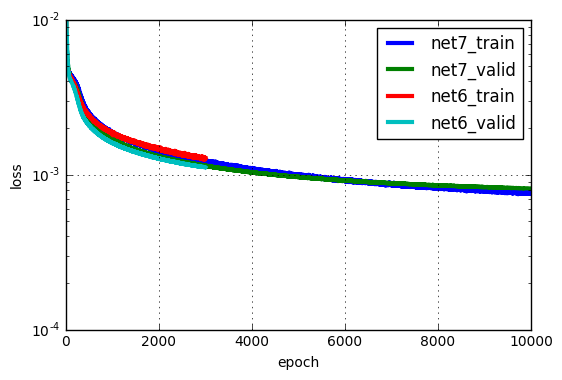

In [5]:
# plot
net7_train_loss = np.array([i["train_loss"] for i in net7.train_history_])
net7_valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])
net6_train_loss = np.array([i["train_loss"] for i in net6.train_history_])
net6_valid_loss = np.array([i["valid_loss"] for i in net6.train_history_])
pyplot.plot(net7_train_loss, linewidth=3, label="net7_train")
pyplot.plot(net7_valid_loss, linewidth=3, label="net7_valid")
pyplot.plot(net6_train_loss, linewidth=3, label="net6_train")
pyplot.plot(net6_valid_loss, linewidth=3, label="net6_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [5]:
# calculate Kaggle score for this model
np.sqrt(0.00081)*48 # normalize to [-1,1]

1.3661039491927398

Even with 10,000 epoch here, it is still not overfit because of the droplayer. And the val_loss drop quite a bit to 0.00081 which translate to a Kaggle score of 1.36610. According to the epoc-loss graph, we could probably got an even better loss score if we further increase epoc, but we will stop from there and try some other improvement consider the resource and time contraint.

## 3. Train Keypoints Separately in Groups 

Noticed from the baseline file that the completeness of each face keypoint lable is different. Some have more than 7000 available whereas others only have less than 3000. I had been using the examples with all keypoints available till this point, and I would like to try and see whether training them in groups based on availability and then combined the model together will help improve the accuracy

In [5]:
## Define early stop method to reduce training time
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

## Group keypoints into specialists based on the data completeness
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]


In [6]:
## Modify the fit function to take each specialist one at a time and combine result at the end 
def fit_specialists(fname_pretrain=None):
    if fname_pretrain:  
        with open(fname_pretrain, 'rb') as f:  
            net_pretrain = pickle.load(f)  
    else:  
        net_pretrain = None 

    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net8_3)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(1e7 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        if net_pretrain is not None:  
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)  

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists_3.pickle', 'wb') as f:
        # this time we're persisting a dictionary with all models:
        pickle.dump(specialists, f, -1)
    return specialists

In [ ]:
## Load net7.pickle trained above as pretrain to reduce epoch needed for early stop
net8_3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.0001)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.0001, stop=0.00001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

fit_specialists(fname_pretrain='net7.pickle')

Note: If we want to get an improved val_loss, I would expect at least some of the specialist will get val_loss less than net7 consider val_loss is based on MSE. I did not run this till the end because the val_loss of the first 2 specialist seems to be far larger than the val_loss in net7. I also tried to adjust the learning rate gradient considered if it is pretrained, we need might either need much lower learning rate from the start or a larger one to first jump out of the local minimum. But neighther seems really helped. 

Sanjay, I think the pretrain load might be broken that it is not correctly loading. Need to look into it more. 8_4.out in github is the result from above query.

## 4. Train a deeper net 

Based on the research VGG (Visual Geometry Group) in Oxford, making the convolution net deeper could help the accuracty with image recognition (http://www.robots.ox.ac.uk/~vgg/research/very_deep/). I had add an additional convolution layer to each round of convolution/pool/dropout and add an additional hidden layer with the same units as others while keep other settings the same. The idea behind this is that 2 convolution layer will recognize more surrounding pixels than 1 layer that if the previous net only recognize an eyeball, this might be able to see an eye all together.

This model takes more than 24hr to train on a g2.2xlarge AWS instance. Rethink on this, an additional hidden layer might not be necessary which increase both training time and memory needed. 

In [ ]:
## Marked all added code with "##"
net9 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1_1', layers.Conv2DLayer),
        ('conv1_2', layers.Conv2DLayer), ##
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2_1', layers.Conv2DLayer),
        ('conv2_2', layers.Conv2DLayer), ##
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3_1', layers.Conv2DLayer),
        ('conv3_2', layers.Conv2DLayer), ##
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('dropout5', layers.DropoutLayer), ## 
        ('hidden6', layers.DenseLayer), ##
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_1_num_filters=32, conv1_1_filter_size=(3, 3), conv1_1_pad=1,
    conv1_2_num_filters=32, conv1_2_filter_size=(3, 3), conv1_2_pad=1,
    pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_1_num_filters=64, conv2_1_filter_size=(3, 3), conv2_1_pad=1,
    conv2_2_num_filters=64, conv2_2_filter_size=(3, 3), conv2_2_pad=1,
    pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_1_num_filters=128, conv3_1_filter_size=(3, 3), conv3_1_pad=1,
    conv3_2_num_filters=128, conv3_2_filter_size=(3, 3), conv3_2_pad=1,
    pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    dropout5_p=0.5,  
    hidden6_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=10000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net9.fit(X, y)

with open('net9.pickle', 'wb') as f:
    pickle.dump(net9, f, -1)


In [6]:
# Load from pickle file after first run
net9 = pickle.load(open('net9.pickle','rb'))
net7 = pickle.load(open('net7.pickle','rb'))

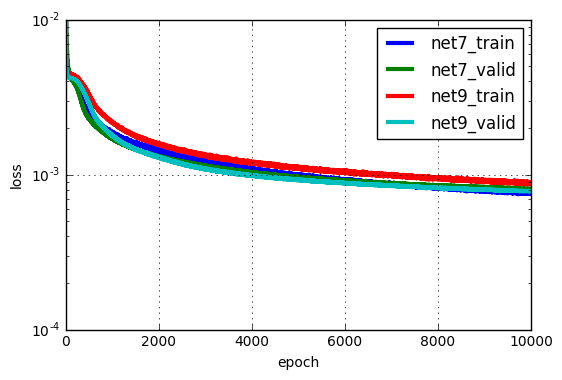

In [7]:
# plot
net9_train_loss = np.array([i["train_loss"] for i in net9.train_history_])
net9_valid_loss = np.array([i["valid_loss"] for i in net9.train_history_])
net7_train_loss = np.array([i["train_loss"] for i in net7.train_history_])
net7_valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])
pyplot.plot(net7_train_loss, linewidth=3, label="net7_train")
pyplot.plot(net7_valid_loss, linewidth=3, label="net7_valid")
pyplot.plot(net9_train_loss, linewidth=3, label="net9_train")
pyplot.plot(net9_valid_loss, linewidth=3, label="net9_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [9]:
# calculate Kaggle score for this model
np.sqrt(0.00078)*48 # normalize to [-1,1]

1.3405670442018183

Making the net deeper does decrease the val_loss, however according to the plot above, it is only a marginal improvement from net7. It now get us to a val_loss of 0.00078 which translate to Kaggle score of 1.34057

## 5. A Even Deeper Net?